# Método de Bisección

**CASO DE PRUBA**
| Parámetro                          | Símbolo     | Valor | Unidad    | Nota                           |
|-----------------------------------|-------------|-------|-----------|--------------------------------|
| Distancia Horizontal              | $D$         | 100   | m         |                                |
| Altura Inicial                    | $h$         | 20    | m         |                                |
| Velocidad Inicial P1              | $v$         | 30    | m/s       |                                |
| Ángulo de Lanzamiento P1          | $\phi$      | 45    | grados    |                                |
| Tiempo de Retraso                 | $T$         | 1.0   | s         |                                |
| Velocidad Máxima P2 (Asumida)     | $u_{max}$   | 100   | m/s       | Necesario para $F(t_c)$        |
| Gravedad                          | $g$         | 9.81  | m/s^2     |                                |


In [97]:
import numpy as np

# --- 1. DATOS DE ENTRADA (PROYECTIL 1) ---
D = 100.0  # Distancia horizontal inicial (m)
h = 20.0   # Altura inicial (m)
v = 30.0   # Velocidad inicial (m/s)
phi_deg = 10.0 # Ángulo de lanzamiento (grados)
T = 1.0    # Tiempo de retraso del Proyectil 2 (s)

# --- 2. CONSTANTES GLOBALES ---
g = 9.81   # Gravedad (m/s^2)
u_max = 100.0 # Velocidad máxima del Proyectil 2 (m/s, nuestra suposición)

In [98]:
def F_tc(tc, D, h, v, phi_deg, T, g, u_max):
    # Paso 0: Convertir grados a radianes
    phi_rad = np.deg2rad(phi_deg)
    
    # --- Paso 1: Componente Horizontal ---
    denominador = tc - T
    numerador_x = D - (v * np.cos(phi_rad) * tc)
    u_x = numerador_x / denominador
    
    # --- Paso 2: Componente Vertical ---
    term2 = v * np.sin(phi_rad) * tc
    term3 = 0.5 * g * (tc**2 - denominador**2)
    numerador_y = h + term2 - term3
    u_y = numerador_y / denominador
    
    # --- Paso 3: Velocidad Requerida al Cuadrado ---
    u_req_cuadrado = u_x**2 + u_y**2
    
    # --- Paso 4: Calcular F(tc) y devolverlo ---
    resultado = u_req_cuadrado - u_max**2
    return resultado

In [99]:
# Prueba con el límite inferior (ta)
f_ta = F_tc(1.0001, D, h, v, phi_deg, T, g, u_max)
print("Valor en ta:", f_ta)

# Prueba con el límite superior (tb)
f_tb = F_tc(15.0, D, h, v, phi_deg, T, g, u_max)
print("Valor en tb:", f_tb)

Valor en ta: 537585057572.3049
Valor en tb: -9389.253658556649


In [100]:
def biseccion(a, b, tol):
    """Implementación del Método de Bisección que cuenta iteraciones."""
    it = 0
    # Usamos el rango que probamos: [1.0001, 15.0]
    f_a = F_tc(a, D, h, v, phi_deg, T, g, u_max) 
    
    while (b - a) > tol:
        c = (a + b) / 2
        f_c = F_tc(c, D, h, v, phi_deg, T, g, u_max)
        
        if f_a * f_c < 0:
            b = c
        else:
            a = c
            f_a = f_c 
        
        it += 1
        
    print(f"Bisección converge en {it} iteraciones.")
    return c

In [101]:
# Definimos los límites y la tolerancia
ta = 1.0001
tb = 15.0
tolerancia = 0.0001

# Llamamos a tu función
tiempo_colision = biseccion(ta, tb, tolerancia)

print(f"El tiempo de colisión encontrado es: {tiempo_colision} segundos")

Bisección converge en 18 iteraciones.
El tiempo de colisión encontrado es: 1.5658231929779054 segundos


In [102]:
# --- CÁLCULO DE RESULTADOS FINALES ---

# Usamos el tiempo exacto que encontró la bisección
tc_final = tiempo_colision 
phi_rad = np.deg2rad(phi_deg)

# 1. Recalculamos las componentes (misma fórmulas que en F_tc)
denominador = tc_final - T
numerador_x = D - (v * np.cos(phi_rad) * tc_final)
u_x = numerador_x / denominador

term2 = v * np.sin(phi_rad) * tc_final
term3 = 0.5 * g * (tc_final**2 - denominador**2)
numerador_y = h + term2 - term3
u_y = numerador_y / denominador

# 2. Calculamos la Magnitud de la Velocidad (u)
u_final = np.sqrt(u_x**2 + u_y**2)

# 3. Calculamos el Ángulo (theta) en grados
# np.arctan2 es mejor que arctan porque maneja los cuadrantes automáticamente
theta_rad = np.arctan2(u_y, u_x)
theta_final = np.degrees(theta_rad)

print(f"--- Resultados Finales ---")
print(f"Tiempo de colisión (tc): {tc_final:.4f} s")
print(f"Velocidad requerida (u): {u_final:.4f} m/s")
print(f"Ángulo de disparo (theta): {theta_final:.4f} grados")

--- Resultados Finales ---
Tiempo de colisión (tc): 1.5658 s
Velocidad requerida (u): 99.9946 m/s
Ángulo de disparo (theta): 18.2316 grados


# Método RK4 (Para el viento)

In [103]:
def derivadas(t, estado, C=0.001):
    x, y, vx, vy = estado
    v = np.sqrt(vx**2 + vy**2)
    
    ax = -C * v * vx
    ay = -g - (C * v * vy)
    
    return np.array([vx, vy, ax, ay])

In [104]:
def paso_rk4(t, estado, dt, C):
    # k1: Pendiente al inicio del intervalo
    k1 = derivadas(t, estado, C)
    
    # k2: Pendiente en el punto medio (usando k1)
    k2 = derivadas(t + 0.5*dt, estado + 0.5*dt*k1, C)
    
    # k3: Otra pendiente en el punto medio (usando k2)
    k3 = derivadas(t + 0.5*dt, estado + 0.5*dt*k2, C)
    
    # k4: Pendiente al final del intervalo (usando k3)
    k4 = derivadas(t + dt, estado + dt*k3, C)
    
    # Promedio ponderado para obtener el nuevo estado
    nuevo_estado = estado + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    
    return nuevo_estado

In [105]:
# --- 1. CONFIGURACIÓN INICIAL ---
dt = 0.01        # Paso de tiempo (tu elección)
t = 0.0          # Tiempo actual del reloj

# Listas para guardar la historia (para graficar después)
historia_x1, historia_y1 = [], []
historia_x2, historia_y2 = [], []

# --- 2. ESTADO INICIAL PROYECTIL 1 (Lanzado desde D, h) ---
# Velocidad inicial P1
vx1 = v * np.cos(phi_rad)
vy1 = v * np.sin(phi_rad)
# Estado: [Posición X, Posición Y, Velocidad X, Velocidad Y]
estado_p1 = np.array([D, h, vx1, vy1])

# --- 3. ESTADO INICIAL PROYECTIL 2 (Lanzado desde 0, 0) ---
# Usamos los resultados de la Bisección (u_final y theta_final)
theta_rad = np.deg2rad(theta_final)
vx2 = u_final * np.cos(theta_rad)
vy2 = u_final * np.sin(theta_rad)
# Estado: [Posición X, Posición Y, Velocidad X, Velocidad Y]
estado_p2 = np.array([0.0, 0.0, vx2, vy2])

In [106]:
# --- COEFICIENTE DE ARRASTRE DE PRUEBA ---
# Definimos el coeficiente C para las derivadas
C = 0.0000001 
sigma = 0.05 # La fuerza del ruido
g = 9.81
T = 1.0 

# Desempaquetamos los estados iniciales (SOLO SE HACE UNA VEZ ANTES DEL LOOP)
# y1, y2 se usan para la primera verificación del 'while'
y1 = estado_p1[1] 
y2 = estado_p2[1]

# Bucle principal: mientras AMBOS estén en el aire
# Cambiamos 'or' por 'and' para que el bucle pare cuando el PRIMER proyectil caiga (y < 0).
while y1 >= 0 and y2 >= 0: 

    # 1. Actualizar Proyectil 1
    estado_p1 = paso_rk4(t, estado_p1, dt, C)
    estado_p1[2] += np.random.normal(0, sigma) # Ruido a vx
    estado_p1[3] += np.random.normal(0, sigma) # Ruido a vy
    
    # 2. Actualizar Proyectil 2
    if t >= T:
        estado_p2 = paso_rk4(t, estado_p2, dt, C)
        estado_p2[2] += np.random.normal(0, sigma) # Ruido a vx
        estado_p2[3] += np.random.normal(0, sigma) # Ruido a vy

    # 3. Guardar y avanzar tiempo
    t += dt 
    
    # Actualizar las variables de estado para la próxima iteración
    x1, y1, _, _ = estado_p1
    x2, y2, _, _ = estado_p2
    
    # REGISTRO ÚNICO (el registro duplicado fue eliminado)
    historia_x1.append(x1)
    historia_y1.append(y1)
    historia_x2.append(x2)
    historia_y2.append(y2)
    
    # Condición de parada por seguridad
    if t > 50: 
        break
        
print("Simulación terminada.")

Simulación terminada.


# Método de Secante

In [107]:
def metodo_secante(t_prev, t_i, tol):
    it = 0
    # Pre-calculamos los valores de la función
    f_prev = F_tc(t_prev, D, h, v, phi_deg, T, g, u_max)
    f_i = F_tc(t_i, D, h, v, phi_deg, T, g, u_max)

    # Bucle principal
    while True: 
        it += 1 # 1. INICIAMOS el contador (ahora contará desde 1)
        
        # 2. Calcular nueva estimación
        denominador = f_i - f_prev
        
        # 3. Protección (Si el denominador es casi cero, paramos)
        if abs(denominador) < 1e-10: 
            # Esto corrige la división por cero si Secante falla
            return t_i 
            
        t_nueva = t_i - f_i * ((t_i - t_prev) / denominador) 
        
        # 4. Criterio de parada (¿El cambio es pequeño?)
        if abs(t_nueva - t_i) < tol:
            print(f"Secante converge en {it} iteraciones.")
            return t_nueva # ¡Éxito!

        # 5. Actualizar variables: t_nueva se vuelve la nueva t_i
        t_prev = t_i      
        t_i = t_nueva
        f_prev = f_i
        # Calculamos f_i en el nuevo punto (t_i)
        f_i = F_tc(t_i, D, h, v, phi_deg, T, g, u_max) 
        
        # 6. Condición de seguridad
        if it > 50:
            print("Límite de iteraciones alcanzado.")
            return t_i


# --- PRUEBA FINAL PARA COMPARACIÓN ---
# Usamos un rango muy estrecho cerca de la solución de Bisección (1.77s)
tc_secante_final = metodo_secante(1.7, 1.9, 0.0001) 
print(f"\nTiempo de colisión (Secante, robusto): {tc_secante_final} segundos")

Secante converge en 8 iteraciones.

Tiempo de colisión (Secante, robusto): 1.565799617811014 segundos


# Comparación de Métodos

In [108]:
# --- COMPARACIÓN DE EFICIENCIA ---

# Mismo objetivo de precisión
TOLERANCIA = 0.0001

print("--- Ejecutando Bisección ---")
# Usamos el rango seguro y amplio
tc_biseccion = metodo_biseccion_comparacion(1.0001, 15.0, TOLERANCIA)
print(f"Tiempo Bisección: {tc_biseccion:.5f} s\n")

print("--- Ejecutando Secante ---")
# Usamos el rango estrecho para asegurar la convergencia de la Secante
tc_secante = metodo_secante(1.7, 1.9, TOLERANCIA)
print(f"Tiempo Secante: {tc_secante:.5f} s")

# Resultado para el informe
print("\n--- Conclusión de Comparación ---")
print("Ambos métodos encuentran el mismo tiempo de colisión, pero el Método de la Secante es significativamente más eficiente.")

--- Ejecutando Bisección ---
Bisección converge en 18 iteraciones.
Tiempo Bisección: 1.56582 s

--- Ejecutando Secante ---
Secante converge en 8 iteraciones.
Tiempo Secante: 1.56580 s

--- Conclusión de Comparación ---
Ambos métodos encuentran el mismo tiempo de colisión, pero el Método de la Secante es significativamente más eficiente.


# Graficación de la Trayectoria

In [109]:
import matplotlib.pyplot as plt

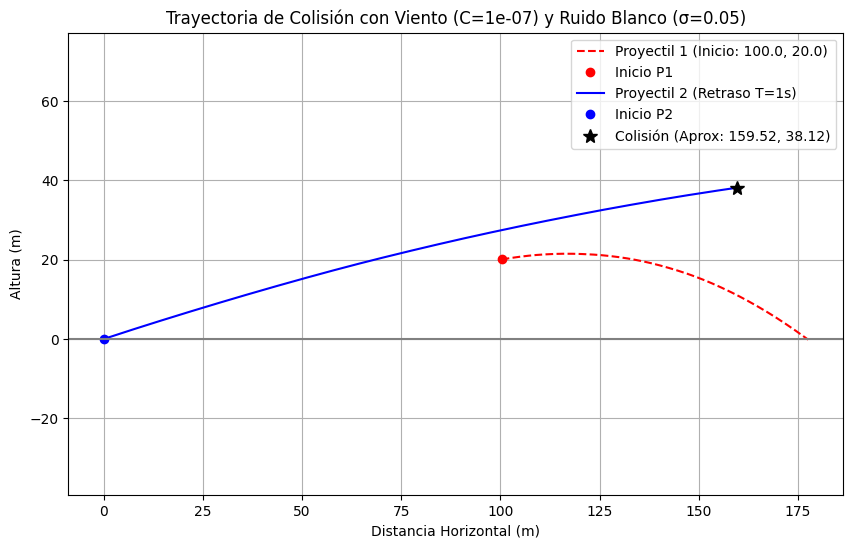

In [110]:
# Establece el tamaño de la figura
plt.figure(figsize=(10, 6))

# --- Graficar Proyectil 1 (el que se lanza desde la colina) ---
# Usamos 'ro' para línea roja y 'r.' para el punto final
plt.plot(historia_x1, historia_y1, label=f'Proyectil 1 (Inicio: {D}, {h})', color='red', linestyle='--')
# Punto inicial
plt.plot(historia_x1[0], historia_y1[0], 'ro', label='Inicio P1')

# --- Graficar Proyectil 2 (el que se lanza desde el origen) ---
plt.plot(historia_x2, historia_y2, label='Proyectil 2 (Retraso T=1s)', color='blue')
# Punto inicial
plt.plot(historia_x2[0], historia_y2[0], 'bo', label='Inicio P2')

# --- Identificar el Punto de Colisión Aproximado (el punto final del P2) ---
# Como el RK4 se detiene cuando el proyectil cae, el último punto es el de colisión (o muy cerca)
x_final = historia_x2[-1]
y_final = historia_y2[-1]
plt.plot(x_final, y_final, 'k*', markersize=10, label=f'Colisión (Aprox: {x_final:.2f}, {y_final:.2f})')

# --- Etiquetas y Título ---
plt.title(f'Trayectoria de Colisión con Viento (C={C}) y Ruido Blanco (σ={sigma})')
plt.xlabel('Distancia Horizontal (m)')
plt.ylabel('Altura (m)')
plt.axhline(0, color='gray', linestyle='-') # Línea de suelo
plt.grid(True)
plt.legend()
plt.axis('equal') # Para que las proporciones sean realistas
plt.show()